 1) CDD30YR                        0.100389
 2) DIVISION                       0.055305
 3) CDD65                          0.050063
 4) HDD65                          0.047104
 5) REPORTABLE_DOMAIN              0.046672
 6) HDD30YR                        0.039484
 7) REGIONC                        0.020670
 8) SWAMPCOL                       0.019349
 9) AIA_Zone                       0.016494
10) DOLELCOL                       0.016024
11) TOTALBTUCOL                    0.014669
12) TOTALDOLCOL                    0.014415
13) DIPSTICK                       0.012927
14) BTUELCOL                       0.011932
15) NWEIGHT                        0.009750
16) COOLTYPE                       0.009167
17) DNTAC                          0.007913
18) KWHCOL                         0.007805
19) TOTALDOLSPH                    0.007230
20) TOTALBTUSPH                    0.007224
21) TOTCSQFT                       0.006298
22) AIRCOND                        0.005619
23) BTUELSPH                    

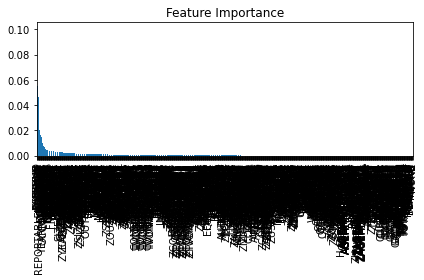

[[ 113    6]
 [   2 2271]]

Classification Report Random Forest
              precision    recall  f1-score   support

           A       0.98      0.95      0.97       119
           B       1.00      1.00      1.00      2273

    accuracy                           1.00      2392
   macro avg       0.99      0.97      0.98      2392
weighted avg       1.00      1.00      1.00      2392

[[ 116    3]
 [   2 2271]]

Classification Report Gradient Boosting
              precision    recall  f1-score   support

           A       0.98      0.97      0.98       119
           B       1.00      1.00      1.00      2273

    accuracy                           1.00      2392
   macro avg       0.99      0.99      0.99      2392
weighted avg       1.00      1.00      1.00      2392

[[ 109   10]
 [  12 2261]]

Classification Report Logistic Regession
              precision    recall  f1-score   support

           A       0.90      0.92      0.91       119
           B       1.00      0.99   

In [57]:
# import pandas
import numpy
import openpyxl
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.feature_selection import RFE

Climate_Region_Pub_labels = ['B', 'B', 'B', 'B', 'A']; # last digit of my passport's number is 4, then: 4 -> 'A', 0,1,2,3 -> 'B'
TEST_SIZE = 0.2
N_ESTIMATORS = 100

def replace_Climate_Region_Pub_to_A_B(dataFrame):
    for i in range(0, 5):
        dataFrame['Climate_Region_Pub'].replace(i+1, Climate_Region_Pub_labels[i], inplace=True)
        
def read_excel(filename, nrows):
    # Parameter `read_only=True` leads to excel rows only being loaded as-needed
    book = openpyxl.load_workbook(filename=filename, read_only=True, data_only=True)
    first_sheet = book.worksheets[0]
    rows_generator = first_sheet.values
    header_row = next(rows_generator)
    data_rows = [row for (_, row) in zip(range(nrows - 1), rows_generator)]
    data = pandas.DataFrame(data_rows, columns=header_row)
    replace_Climate_Region_Pub_to_A_B(data)
    return data

def get_rows_count_excel_file(filename):
    book = openpyxl.load_workbook(filename=filename, read_only=True, data_only=True)
    sheet = book.worksheets[0]
    return sheet.max_row

def get_bad_indexes(dataFrame):
    res_array = []
    for key, col in dataFrame.iteritems():
        index = 0
        for cell in col.values:
            if(isinstance(cell, datetime.datetime) or pandas.isnull(cell) or pandas.isna(cell)):
                if not index in res_array:
                    res_array.append(index)
            index += 1
    return res_array

rows_num = get_rows_count_excel_file('Houses.xlsx') # count rows in excel file
data = read_excel('Houses.xlsx', rows_num) # load rows from excel file
indexes = get_bad_indexes(data) # get numbers of rows with null/NaN/datetime cells
data.drop(indexes, inplace=True) # drop rows with null/NaN/datetime cells

dummy_metromicro = pandas.get_dummies(data['METROMICRO'])
dummy_ur = pandas.get_dummies(data['UR'])

Y = data['Climate_Region_Pub']

X = data.drop(columns=['Climate_Region_Pub', 'METROMICRO', 'UR'])
X = pandas.concat([X, dummy_metromicro, dummy_ur], axis=1, sort=False)

# Calculating features importances
feat_labels = X.columns[0:]
forest = RandomForestClassifier(n_estimators=100, random_state=1)
#forest = RandomForestClassifier()
forest.fit(X, Y)
importances = forest.feature_importances_
indices = numpy.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
# Show features importances
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

X = pandas.concat([data['CDD30YR'],         # fifteen most valuable features
                   data['DIVISION'], 
                   data['CDD65'],
                   data['HDD65'],
                   data['REPORTABLE_DOMAIN'],
                   data['HDD30YR'],
                   data['REGIONC'],
                   data['SWAMPCOL'],
                   data['AIA_Zone'],
                   data['DOLELCOL'],
                   data['TOTALBTUCOL'],
                   data['TOTALDOLCOL'],
                   data['DIPSTICK'],
                   data['BTUELCOL'],
                   data['NWEIGHT']], axis=1, sort=False)

X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size=TEST_SIZE, random_state=0)

# Random Forest Model
forest = RandomForestClassifier(n_estimators=N_ESTIMATORS , random_state=1)
#forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)
confmat_forest_model = confusion_matrix(y_true=y_test, y_pred=y_pred_forest)
print(confmat_forest_model)

print("\nClassification Report Random Forest")
print(classification_report(y_test, y_pred_forest))

# Gradient Boosting model
gBoost = GradientBoostingClassifier(n_estimators=N_ESTIMATORS , learning_rate=0.1, max_depth=3, random_state=0)
#gBoost = GradientBoostingClassifier()
gBoost.fit(X_train, y_train)
y_pred_gBoost = gBoost.predict(X_test)

confmat_gBoost_model = confusion_matrix(y_true=y_test, y_pred=y_pred_gBoost)
print(confmat_gBoost_model)

print("\nClassification Report Gradient Boosting")
print(classification_report(y_test, y_pred_gBoost))

# Logistic Regession model              
X_scaled = preprocessing.scale(X)
X_train, X_test, y_train, y_test =  train_test_split(X_scaled, Y, test_size=TEST_SIZE, random_state=0)
logReg = LogisticRegression(С=0.1)
logReg.fit(X_train, y_train)
y_pred_logReg = logReg.predict(X_test)

confmat_logReg_model = confusion_matrix(y_true=y_test, y_pred=y_pred_logReg)
print(confmat_logReg_model)

print("\nClassification Report Logistic Regession")
print(classification_report(y_test, y_pred_logReg))

In [36]:
# Отчёт:
#
# Наиболее точная модель с дефолтными параметрами - градиентный бустинг, наимнее точная - логистическая регрессия.
# При увеличении тренировачного набора и уменьшении тестового, точность немного увеличивается. Увеличение количества деревьев в моделях 
# GradientBoostingClassifier и RandomForestClassifier не влияет на точность.
# При изменении значений параметров 'learning_rate' и 'max_depth' для Gradient Boosting, точность уменьшается.
# Изменение значения параметра 'C' в пределах [0.1 ; 10] для LogisticRegression немного улучшает точность, лучшие значения достигаются при C = 0.1. 
# Таким образом, наилучших значений модели GradientBoostingClassifier и RandomForestClassifier достигают при дефолтных значениях параметров,
# для LogisticRegression целесообразно попробовать разные значения параметра 'C'.